In [41]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
%matplotlib inline

In [42]:
def load_image(path):
    img = cv2.imread(path)
    return img

In [ ]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to to show a list of images
    """
    rows = len(img_list)
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, rows):
        for j in range(0, cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            #k = i * cols + j
            img_name = img_labels[i][j]
            img = img_list[i][j]
            if len(img.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"
                img = np.reshape(img, (img.shape[0], img.shape[1]))

            if not show_ticks:
                ax.axis("off")

            ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)

    fig.suptitle(title, fontsize=12, fontweight='bold', y=1)
    fig.tight_layout()
    plt.show()

    return

In [43]:
def measure_distortion():
    
    # prepare object points
    nx = 9
    ny = 6
    objpoints =[]
    imgpoints  = []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] =np.mgrid[0:9, 0:6].T.reshape(-1,2)


    # Get list of calibarion images
    fnames = glob.glob('camera_cal/*.jpg')

    for fname in fnames:
    
        # Read image
        img = cv2.imread(fname)

        # Convert image to gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # Check if corners are found
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            #Draw corners on the original image
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return objpoints, imgpoints

In [44]:
def correct_distortion(img, objpoints, imgpoints):
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

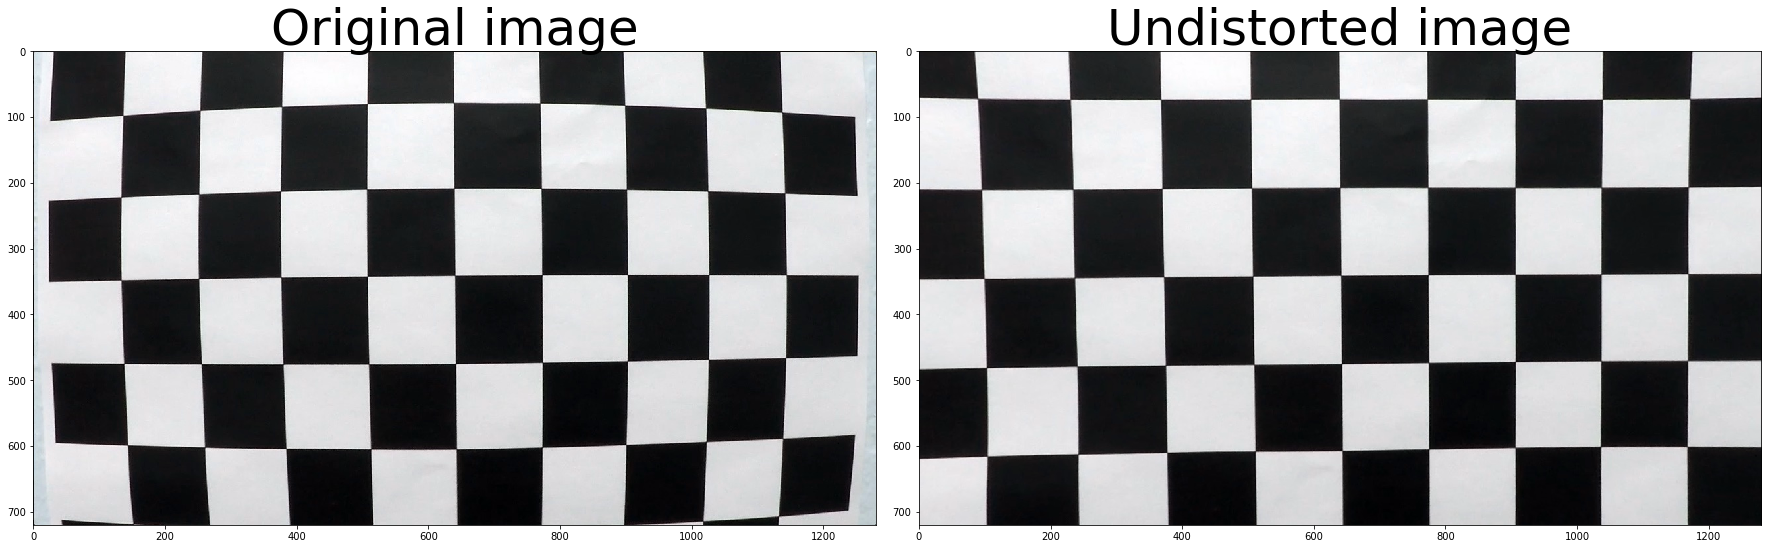

In [45]:
objpts, imgpts = measure_distortion()
img = cv2.imread('camera_cal/calibration1.jpg')

undist = correct_distortion(img, objpts, imgpts)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0)

In [46]:
test_images_paths = glob.glob('test_images/*.jpg')

test_images_filenames = list(map(lambda img_path: img_path.split('/')[-1].split('.')[0], test_images_paths))
undistort_test_images_filenames = list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name),test_images_filenames))
result = list(zip(test_images_filenames, undistort_test_images_filenames))
result

[('test_images\\straight_lines1', 'undistorted_test_images\\straight_lines1'),
 ('test_images\\straight_lines2', 'undistorted_test_images\\straight_lines2'),
 ('test_images\\test1', 'undistorted_test_images\\test1'),
 ('test_images\\test2', 'undistorted_test_images\\test2'),
 ('test_images\\test3', 'undistorted_test_images\\test3'),
 ('test_images\\test4', 'undistorted_test_images\\test4'),
 ('test_images\\test5', 'undistorted_test_images\\test5'),
 ('test_images\\test6', 'undistorted_test_images\\test6')]

In [50]:
test_images = list(map(lambda img_path: load_image(img_path),test_images_paths))
undistort_test_images = map(lambda img: correct_distortion(img, objpts, imgpts),test_images)

In [48]:
# Apply gradient
def apply_sobel(img, orient='x', thresh_min=0, thresh_max=255):
   
    # convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x or y direction
    if orient =='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    # Covert pixels to 8 bits 0-255
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel))
    
    # Create mask where strong gradient within the threshold set to 1
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)]=1
    return binary_output
    
    

In [49]:
binary_image = apply_sobel(undist, orient='x', thresh_min=30, thresh_max=100)

Text(0.5, 1.0, 'binary_image  image')

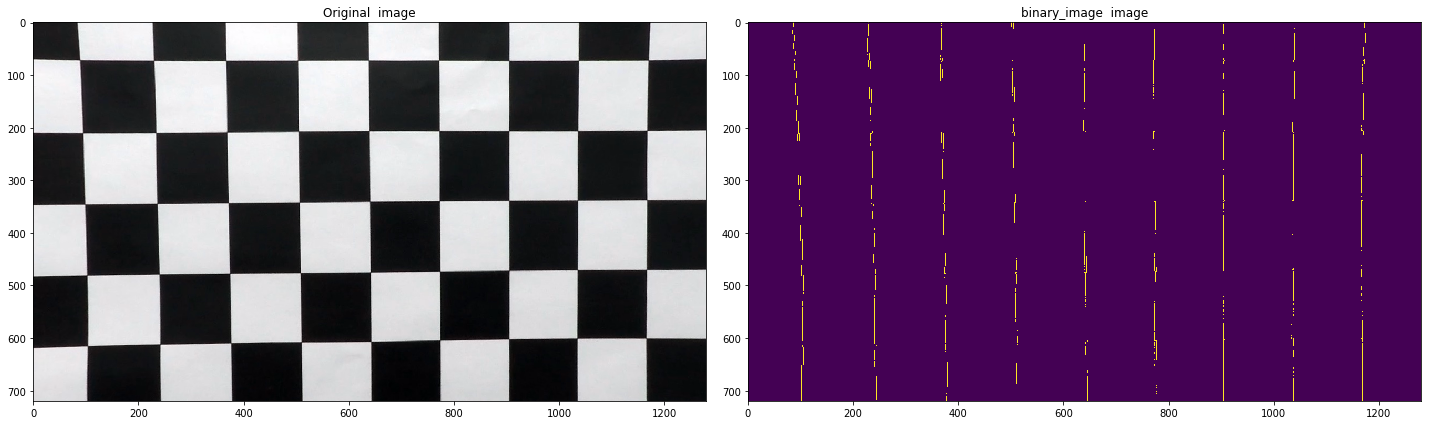

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original  image')

ax2.imshow(binary_image)
ax2.set_title('binary_image  image')


In [12]:
# Apply gradient magnitude
def apply_sobel_mag(img, kernel_size=3, thresh_min=0, thresh_max=255):
   
    # convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x and y direction
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    
    # Calculate magnitude of the gradient
    gradmag = np.sqrt(abs_sobel_x**2+abs_sobel_y**2)
    
    # Covert pixels to 8 bits 0-255
    scaled_sobel = (255*gradmag/np.max(gradmag))
    plt.imshow(scaled_sobel)
    
    # Create mask where strong gradient within the threshold set to 1
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)]=1
    return binary_output
    

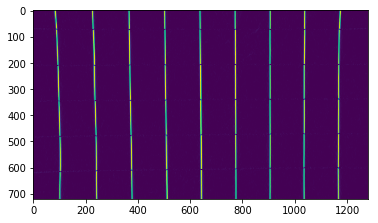

In [13]:
binary_image2 = apply_sobel_mag(undist, kernel_size=15, thresh_min=50, thresh_max=150)

Text(0.5, 1.0, 'binary_image  image')

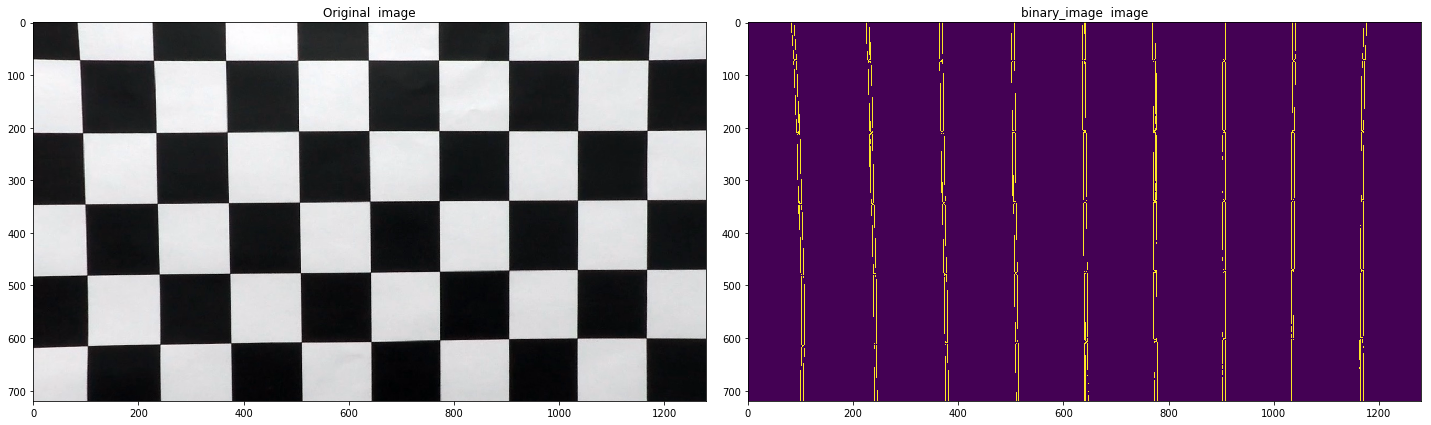

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original  image')

ax2.imshow(binary_image2)
ax2.set_title('binary_image  image')


In [15]:
# Apply gradient direction
def apply_sobel_dir(img, kernel_size=3, thresh_min=0, thresh_max=np.pi/2):
   
    # convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x and y direction
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    
    # Calculate magnitude of the gradient
    graddir= np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Covert pixels to 8 bits 0-255
    #scaled_sobel = (255*gradmag/np.max(gradmag))
    
    # Create mask where strong gradient within the threshold set to 1
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir>=thresh_min) & (graddir<=thresh_max)]=1
    return binary_output
    

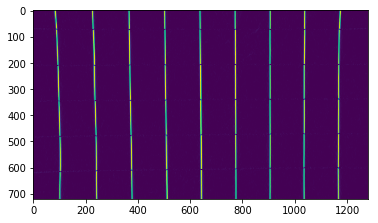

In [16]:
binary_image3 = apply_sobel_mag(undist, kernel_size=15, thresh_min=0.7, thresh_max=1.3)

Text(0.5, 1.0, 'binary_image warped image')

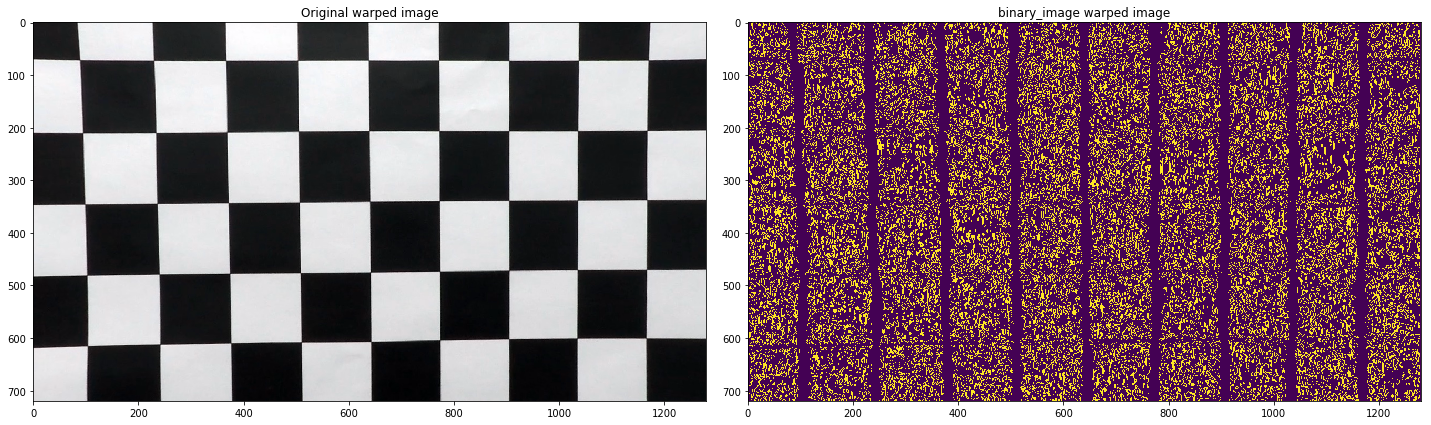

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original warped image')

ax2.imshow(binary_image3)
ax2.set_title('binary_image warped image')


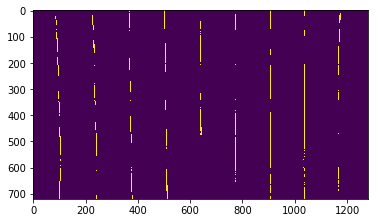

In [18]:
gradx = apply_sobel(undist, orient='x', thresh_min=30, thresh_max=150)
grady = apply_sobel(undist, orient='y', thresh_min=30, thresh_max=150)
grad_mag = apply_sobel_mag(undist, kernel_size=3, thresh_min=30, thresh_max=150)
grad_dir = apply_sobel_mag(undist, kernel_size=3, thresh_min=0.7, thresh_max=1.3)

combined = np.zeros_like(grad_dir)
combined[((gradx == 1) & (grady==1) |(grad_mag == 1) & (grad_dir==1) )] =1
plt.imshow(combined)

In [19]:
def color_thresh(img, th_min=0, th_max=255, desired_color_channel='hls'):
    # convert image to desired color space
    if desired_color_channel == 'hls':
        # convert image to hls color space
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        # Extract s-channel
        s_channel = hls[:,:,2]
    elif desired_color_channel == 'hsv':
        # convert image to hsv color space
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Extract s-channel
        s_channel = hsv[:,:,1]
    
    # Create binary image
    binary_output = np.zeros_like(s_channel)
    # Apply threshold
    binary_output[(s_channel>th_min) & (s_channel<=th_max)]=1
    # Return the binary output
    return binary_output
    


In [20]:
grad_thresh = apply_sobel(undist, orient='x', thresh_min=30, thresh_max=80)

color_thresh1 = color_thresh(undist, th_min=170, th_max=255, desired_color_channel='hls')

Text(0.5, 1.0, 'color thresh')

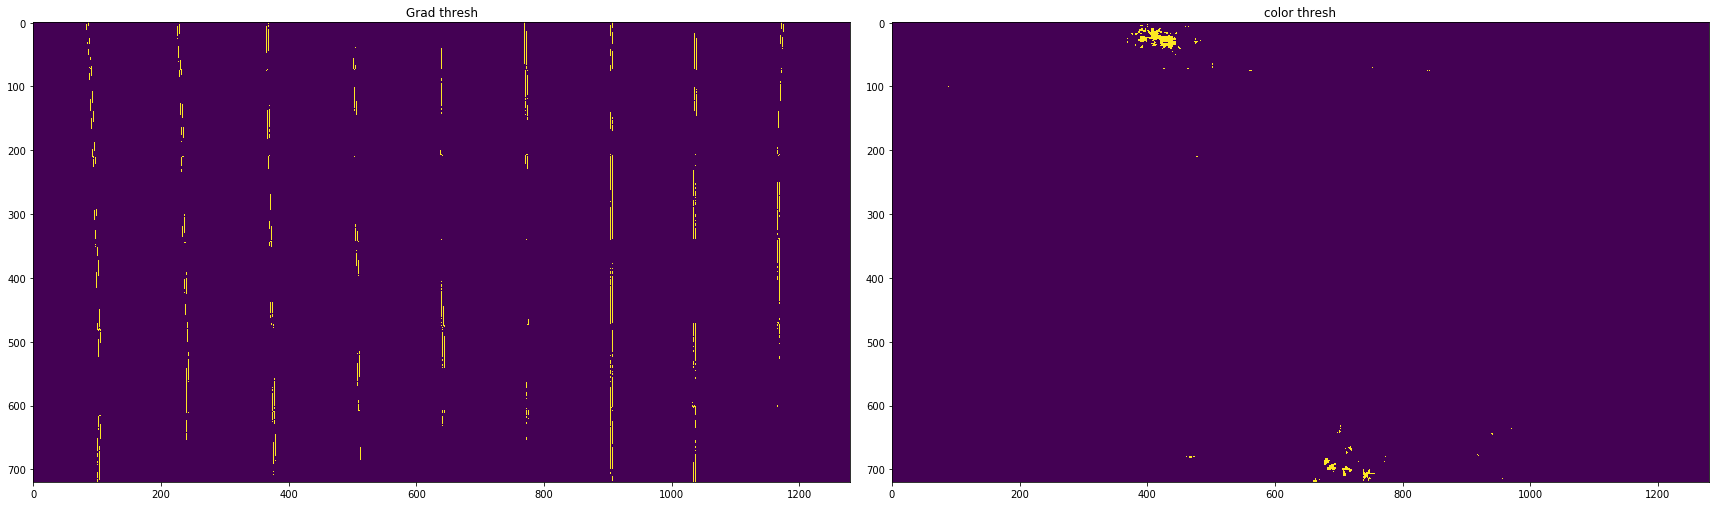

In [21]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grad_thresh)
ax1.set_title('Grad thresh')
ax2.imshow(color_thresh1)
ax2.set_title('color thresh')

In [22]:
def pipeline(img, c_thresh=(170, 255), gradx_thresh=(30, 100)):
    # Make copy from original image
    image = np.copy(img)
    
    # Get gradient image
    grad_bin_image = apply_sobel(image, orient='x', thresh_min=gradx_thresh[0], thresh_max=gradx_thresh[1])
    
    # get color thresh image 
    color_thresh_image =  color_thresh(image, th_min=c_thresh[0], th_max=c_thresh[1], desired_color_channel='hls')
    
    
    # stack each channel
    color_image = np.dstack((np.zeros_like(grad_bin_image),grad_bin_image, color_thresh_image))*255
    
    plt.imshow(color_image)
    
    # Combined the two images
    combined_binary = np.zeros_like(grad_bin_image)
    combined_binary[(grad_bin_image==1) | (color_thresh_image==1)]=1
    
    # Return color image
    return combined_binary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


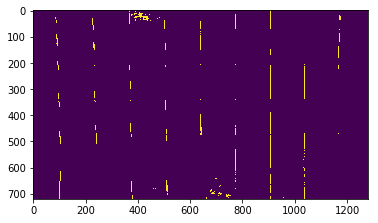

In [23]:
combined_binary = pipeline(undist)
plt.imshow(combined_binary)

In [30]:
# perform perspective transform
def measure_warp(img):
    img_size = (img.shape[1], img.shape[0])
    # Define source coordinate points
    #src = np.float32([[537, 500],[278, 697],[1082, 675], [767,500]])
    src = np.float32([[560, 500],[235, 697],[1082, 675], [767,500]])
    
    # Define desired  coordinate points
    #dst = np.float32([[276, 0],[278, 697],[1082, 675],[1074, 0]])
    dst = np.float32([[276, 0],[180, 697],[1082, 675],[1074, 0]])
    
    # get perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Get inverse perspective transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

In [31]:
def get_warpers(img):
    
     # Get image size
    img_size = (img.shape[1], img.shape[0])
    
    # Retrieve  perspective transfomation matrices
    M, Minv = measure_warp(img)
    
    # warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # unwarp the image
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped, unwarped

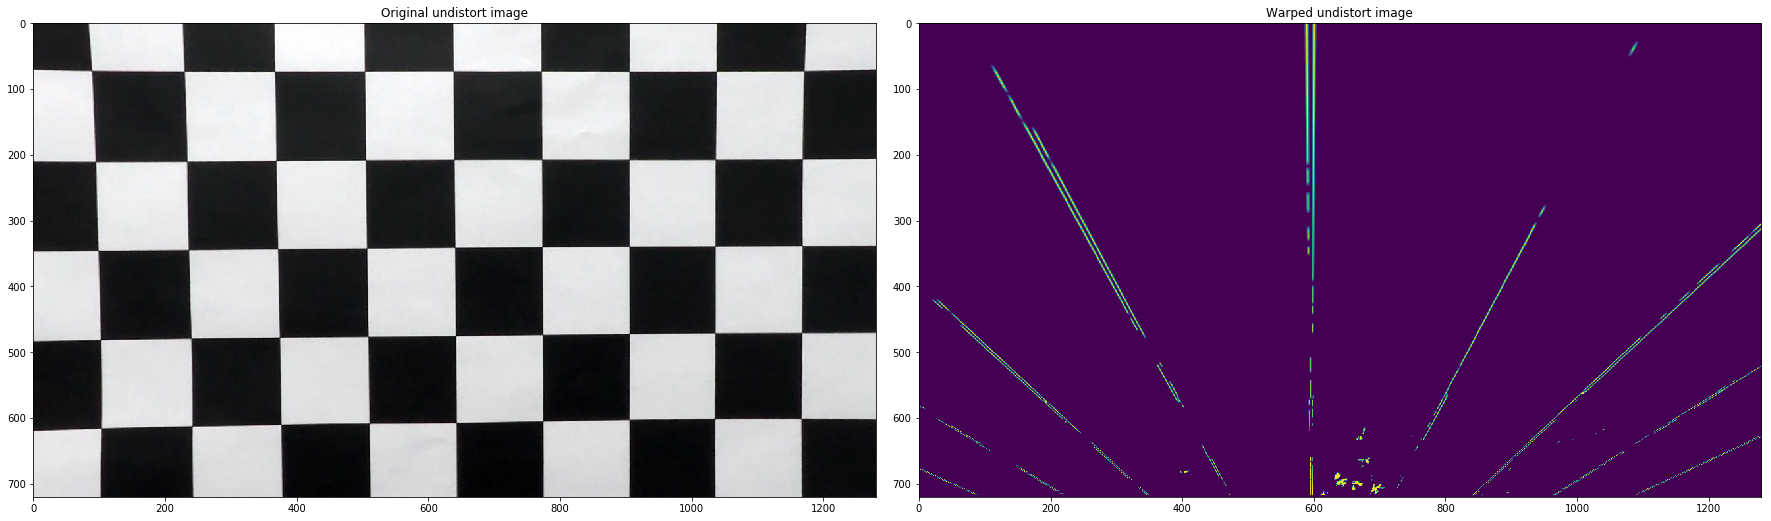

In [32]:
M, Minv, warped_binary, unwarped = get_warpers(combined_binary)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()                            
ax1.imshow(undist)
ax1.set_title('Original undistort image')
ax2.imshow(warped_binary)
ax2.set_title('Warped undistort image')
f.subplots_adjust(left=0, right=1, top=0.8, bottom=0)

In [33]:
def hist(img):
   
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    # Return histogram
    return histogram
    

In [34]:
# visualize histogram
histogram = hist(warped)
plt.plot(histogram)

NameError: name 'warped' is not defined

In [35]:
def find_lane_pixels(binary_warped):
    # Get the histogram of the bottom half of the image
    histogram = hist(binary_warped)
    print(histogram,'histogram')
    
    # Create output image to drawn on for  visualization purpose
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Calculate midpoint of the histogram
    midpoint = histogram.shape[0]//2
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # SLIDING WINDOWS HYPERPARAMETERS
    
    # Choose the number of sliding windows
    nwindows = 20
    
    # Set the width of the windows -+ margin
    margin = 100
    
    # Set minimum of pixels to found to recenter windows
    minpix = 50
    
    # Set height of windows base on nwindows and image shape
    window_height = int(binary_image.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
     # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
       
    return leftx, lefty, rightx, righty, out_img  

In [36]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # calculate radius of curvature of the lanes in meters
    
    # Define x and y conversions from pixel to world space
    ym_per_pixel = 30/720 # meters per pixel in y dimension
    xm_per_pixel = 3.7/700 # meters per pixel in x dimension
    
    y_eval = binary_image.shape[0]
    
    # Fit a second order polynomial to each using `np.polyfit` in world space (meters)
    left_fit_cr = np.polyfit(lefty*ym_per_pixel, leftx*xm_per_pixel, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pixel, rightx*xm_per_pixel, 2)
    
    # Calculate radius of curvature of both left and right lanes
    left_curvature_rad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pixel + left_fit_cr[1])**2)**1.5/np.absolute(2*left_fit_cr[0])
    right_curvature_rad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pixel + right_fit_cr[1])**2)**1.5/np.absolute(2*right_fit_cr[0])
    return left_fit, right_fit, left_curvature_rad, right_curvature_rad, out_img

left_fit, right_fit, left_curv_rad, right_curv_rad, out_img = fit_polynomial(warped)

plt.imshow(out_img)

NameError: name 'warped' is not defined

In [37]:
def draw_lane(undistorted, warped_binary, l_fit, r_fit, l_rad, r_rad, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    l_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    r_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped_binary blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_binary.shape[1], warped_binary.shape[0])) 
    #newwarp = unwarp(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    # Annotate image with lane curvature estimates
    cv2.putText(result, "L. Curvature: %.2f km" % (l_rad/1000), (50,50), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    cv2.putText(result, "R. Curvature: %.2f km" % (r_rad/1000), (50,80), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    # Annotate image with position estimate
    cv2.putText(result, "C. Position: %.2f m" % ((np.average((l_fitx + r_fitx)/2) - warped_binary.shape[1]//2)*3.7/700), (50,110), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    return result

In [39]:
output = draw_lane(undist, warped_binary, left_fit, right_fit, left_curv_rad, right_curv_rad, Minv)

NameError: name 'left_fit' is not defined

In [40]:
plt.imshow(output)

NameError: name 'output' is not defined